# MixFlows with discretized Hamiltonian dynamics

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import sys, time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
from aux import LogSumExp

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [36]:
def lqN(x,rho,u,N,lq0,L,epsilon,grad_lp,xi=np.pi/16):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm # laplacian momentum
    if N==0: return lq0(x_,rho_,u_)
    w=np.zeros((N,x_.shape[1]))
    w[0,:]=lq0(x_,rho_,u_)
    lJ=np.zeros(x_.shape[1])
    
    # CACHEING FOR DEBUGGING
    xs=np.zeros((N,x.shape[0],x.shape[1]))
    xs[0,:,:]=x_
    rhos=np.zeros((N,rho.shape[0],rho.shape[1]))
    rhos[0,:,:]=rho_
    us=np.zeros((N,u.shape[0]))
    us[0,:]=u_
    ###
    
    for n in range(N-1):
        print('Flow: '+str(n+1))
        x_,rho_,u_,tlJ,_,_,_=flow(1,x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,'bwd')
        lJ=lJ+tlJ
        print('x: '+str(x_[0,0]))
        print('rho: '+str(rho_[0,0]))
        print('J: '+str(np.exp(tlJ[0])))
        print('total J: '+str(np.sum(np.exp(lJ[0]))))
        w[n+1,:]=lq0(x_,rho_,u_)+tlJ
        print('Gaussian weight: '+str(np.exp(gauss_lp(x_,mu0,sigma0)[0])))
        print('Laplace weight: '+str(np.exp(lap_lm(rho_)[0])))
        print('weight: '+str(np.exp(w[n+1,0])))
        print('sum weights: '+str(np.sum(np.exp(w[:(n+2),0]))))
        print()
        
        # CACHEING FOR DEBUGGING
        xs[n+1,:,:]=x_
        rhos[n+1,:,:]=rho_
        us[n+1,:]=u_
        ###
    # end for
    return LogSumExp(w)-np.log(N),xs,rhos,us

def randqN(size,N,randq0,L,epsilon,grad_lp,xi=np.pi/16):
    if N==1: return randq0(size)
    K=np.random.randint(low=0,high=N,size=size)
    lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm # laplacian momentum
    x,rho,u=randq0(size)
    for n in range(N):
        tx,trho,tu,_,_,_,_=flow(1,x[:,K>=n+1],rho[:,K>=n+1],u[K>=n+1],L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,'fwd') # update those with large enough K
        x[:,K>=n+1]=tx
        rho[:,K>=n+1]=trho
        u[K>=n+1]=tu
    # end for
    return x,rho,u
    


def flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lJ=np.zeros(x_.shape[1])
    if steps==0: return x_,rho_,u_,lJ
    
    # CACHEING FOR DEBUGGING
    xs=np.zeros((steps+1,x.shape[0],x.shape[1]))
    xs[0,:,:]=x_
    rhos=np.zeros((steps+1,rho.shape[0],rho.shape[1]))
    rhos[0,:,:]=rho_
    us=np.zeros((steps+1,u.shape[0]))
    us[0,:]=u_
    ###
    for n in range(steps):
        #print(str(n+1)+'/'+str(steps),end='\r')
        if direction=='fwd': x_,rho_,u_,tmplJ=forward( x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        if direction=='bwd': x_,rho_,u_,tmplJ=backward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        lJ=lJ+tmplJ
        
        # CACHEING FOR DEBUGGING
        xs[n+1,:,:]=x_
        rhos[n+1,:,:]=rho_
        us[n+1,:]=u_
        ###
    # end for
    return x_,rho_,u_,lJ,xs,rhos,us

def forward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_=Ham(x,rho,L,epsilon,grad_lp,grad_lm)
    lJ=lm(rho_)
    u_=(u+xi)%1
    rho_=Qm((Fm(rho_)+pseudo_random(x_,u_))%1)
    lJ=lJ-lm(rho_)
    return x_,rho_,u_,lJ

def backward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lJ=lm(rho_)
    rho_=Qm((Fm(rho_)-pseudo_random(x_,u_))%1)
    lJ=lJ-lm(rho_)
    u_=(1.+u_-xi)%1
    x_,rho_=Ham(x_,rho_,L,-epsilon,grad_lp,grad_lm)
    return x_,rho_,u_,lJ

def Ham(x,rho,L,epsilon,grad_lp,grad_lm):
    x_,rho_=np.copy(x),np.copy(rho)
    for l in range(L):
        rhot = rho_  + epsilon*grad_lp(x_)/2
        x_    = x_   - epsilon*grad_lm(rhot)
        rho_  = rhot + epsilon*grad_lp(x_)/2
    # end for
    return x_,rho_

def lap_lm(rho): return -np.sum(np.abs(rho),axis=0)-rho.shape[0]*np.log(2.) #(M,d)->(d,)
def lap_Fm(rho): return 0.5-0.5*np.sign(rho)*np.expm1(-np.abs(rho)) #(M,d)->(M,d)
def lap_Qm(p)  : return np.sign(0.5-p)*np.log1p(-2.*np.abs(p-0.5)) #(M,d)->(M,d)
def lap_gradlm(rho): return -np.sign(rho) #(M,d)->(M,d)

def gauss_lp(x,mu,sigma): return -0.5*np.sum((x-mu)**2,axis=0)/sigma**2-x.shape[0]*np.log(2*np.pi*sigma**2)/2
def pseudo_random(x,u): return 0.5*np.sin(2*x+u)+0.5

In [69]:
# target specification
def lp(x): return gauss_lp(x,0.,1.)
def grad_lp(x): return -x

# ref specification
mu0=2.
sigma0=0.3
def lq0(x,rho,u): return gauss_lp(x,mu0,sigma0)+lap_lm(rho)
def randq0(size): return mu0+sigma0*np.random.randn(1,size),np.random.laplace(size=(1,size)),np.random.rand(size)

ss=1000
q0_sample=mu0+sigma0*np.random.randn(1,ss)

## Forward pass

In [70]:
# settings
steps=20
ss=1000
x=mu0+sigma0*np.random.randn(1,ss)
rho=np.random.laplace(size=(1,ss))
u=np.random.rand(ss)
L=50
epsilon=0.1
lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm
xi=np.pi/16

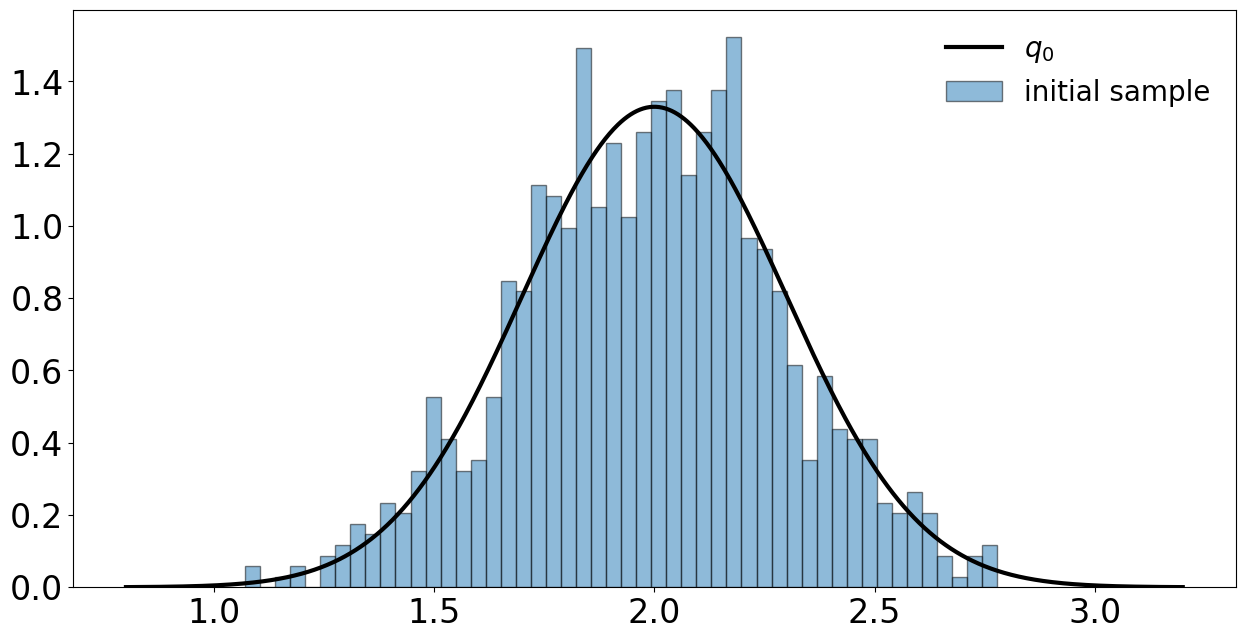

In [72]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(gauss_lp(ttx[np.newaxis,:],mu0,sigma0)),c='black',lw=3,label=r'$q_0$')
plt.hist(x[0,:],alpha=0.5,density=True,bins=50,ec='black',label='initial sample');
plt.legend(fontsize='small',frameon=False)

In [73]:
xp,rhop,up,lJ,xs,rhos,us=flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='fwd')

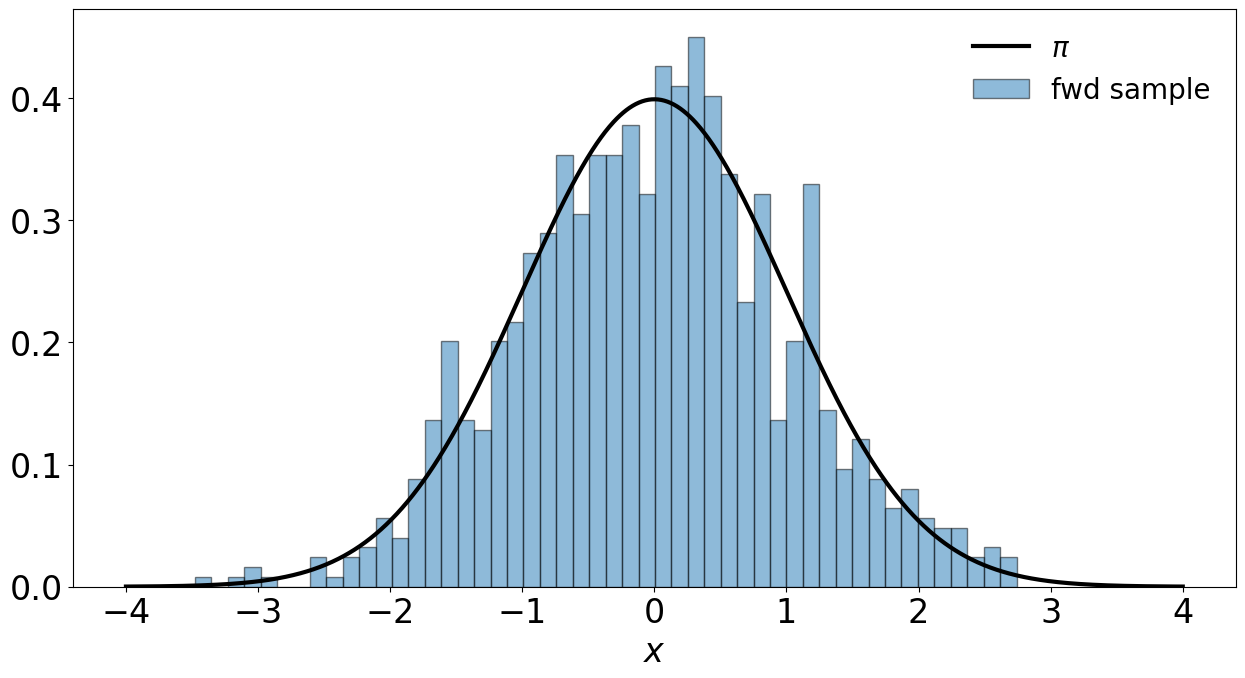

In [74]:
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])),c='black',lw=3,label=r'$\pi$')
plt.hist(xp[0,:],alpha=0.5,density=True,bins=50,ec='black',label='fwd sample');
plt.xlabel(r'$x$')
plt.legend(fontsize='small',frameon=False)

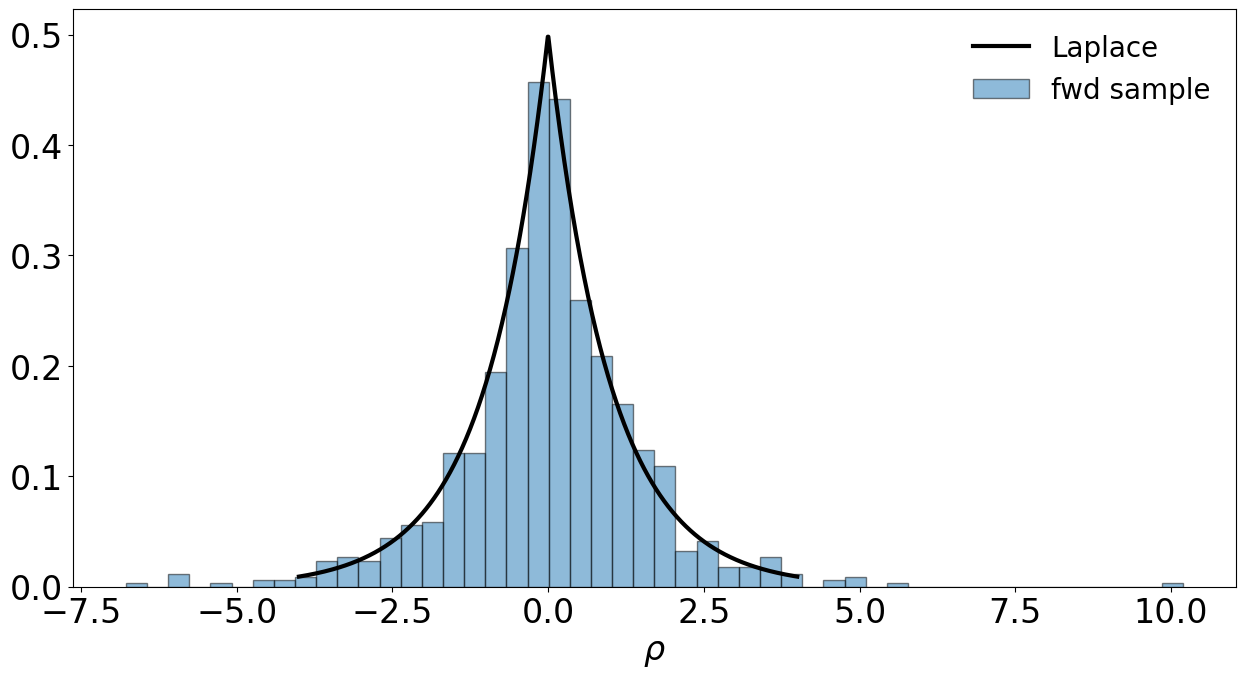

In [75]:
ttrho=np.linspace(-4,4,1000)
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])),c='black',lw=3,label='Laplace')
plt.hist(rhop[0,:],alpha=0.5,density=True,bins=50,ec='black',label='fwd sample');
plt.xlabel(r'$\rho$')
plt.legend(fontsize='small',frameon=False)

Text(0.5, 0, '$u$')

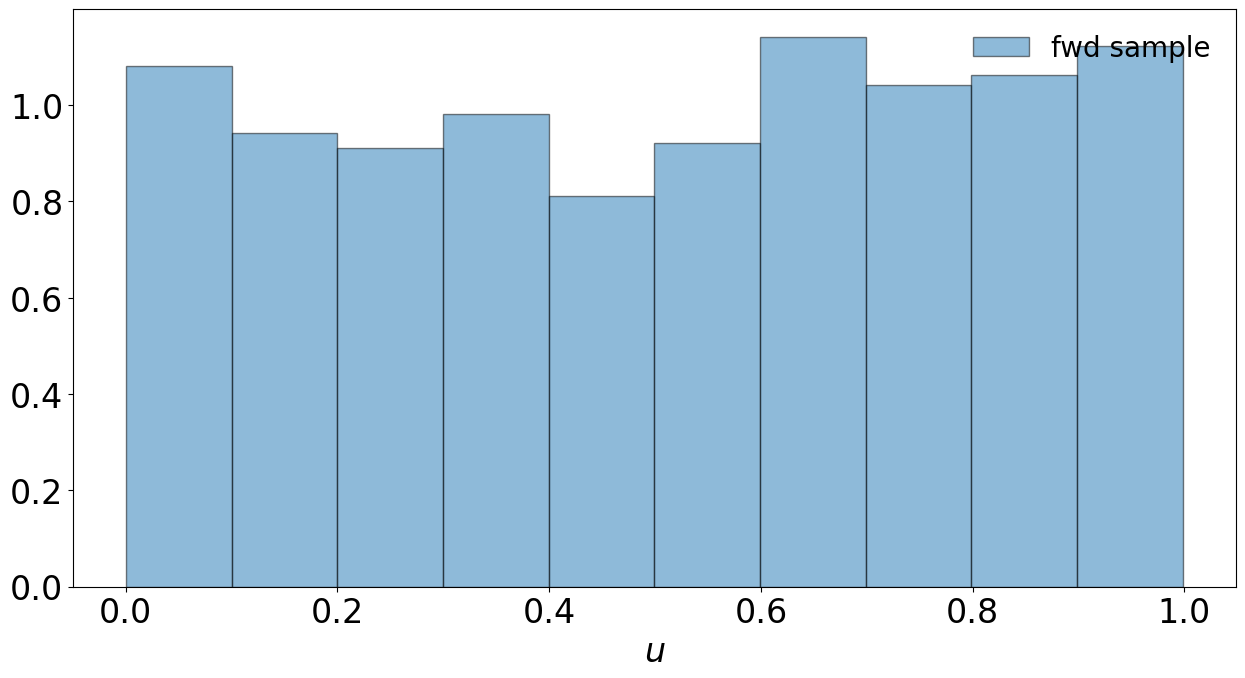

In [76]:
plt.hist(up,alpha=0.5,density=True,bins=10,ec='black',label='fwd sample');
plt.legend(fontsize='small',frameon=False)
plt.xlabel(r'$u$')

## Backward pass

In [77]:
xpp,rhopp,upp,lJ,xps,rhops,ups=flow(steps,xp,rhop,up,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')

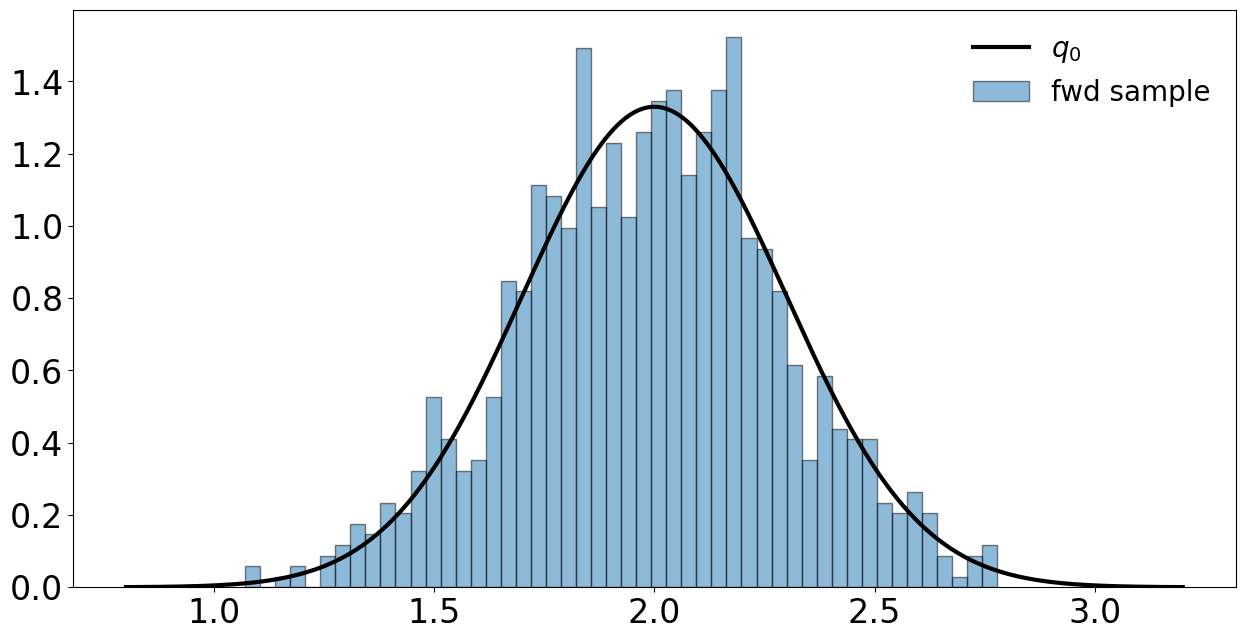

In [78]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(gauss_lp(ttx[np.newaxis,:],mu0,sigma0)),c='black',lw=3,label=r'$q_0$')
plt.hist(xpp[0,:],alpha=0.5,density=True,bins=50,ec='black',label='fwd sample');
plt.legend(fontsize='small',frameon=False)

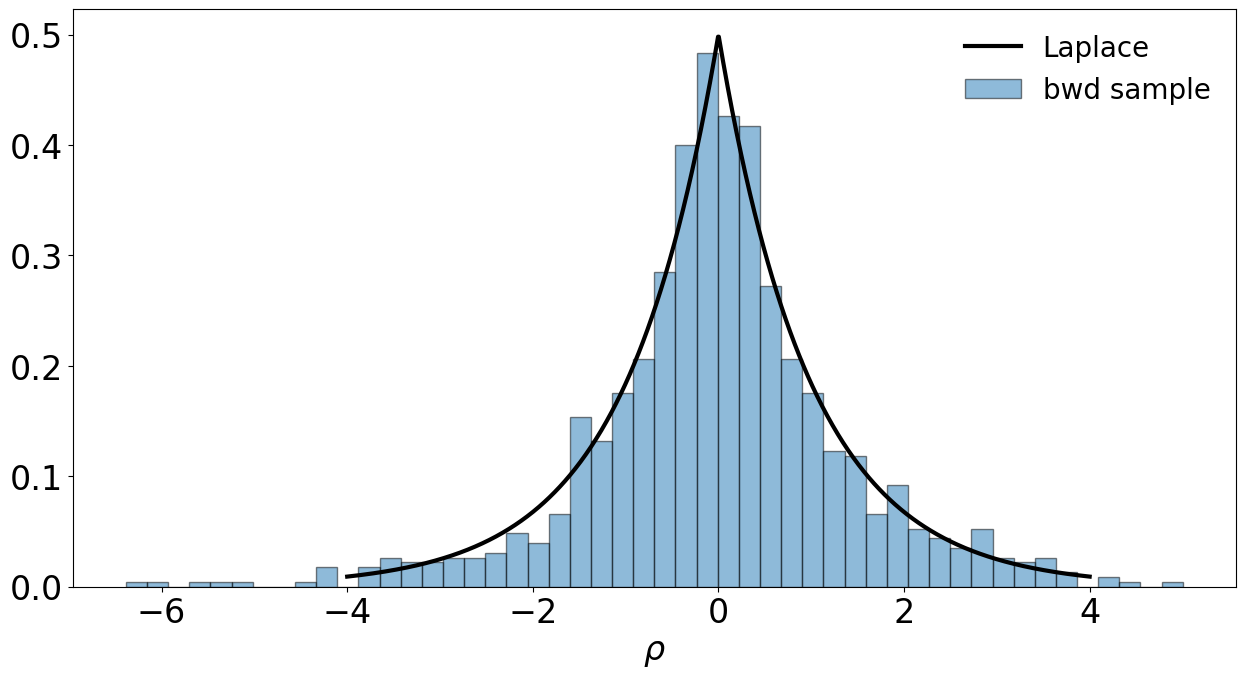

In [79]:
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])),c='black',lw=3,label='Laplace')
plt.hist(rhopp[0,:],alpha=0.5,density=True,bins=50,ec='black',label='bwd sample');
plt.xlabel(r'$\rho$')
plt.legend(fontsize='small',frameon=False)

Text(0.5, 0, '$u$')

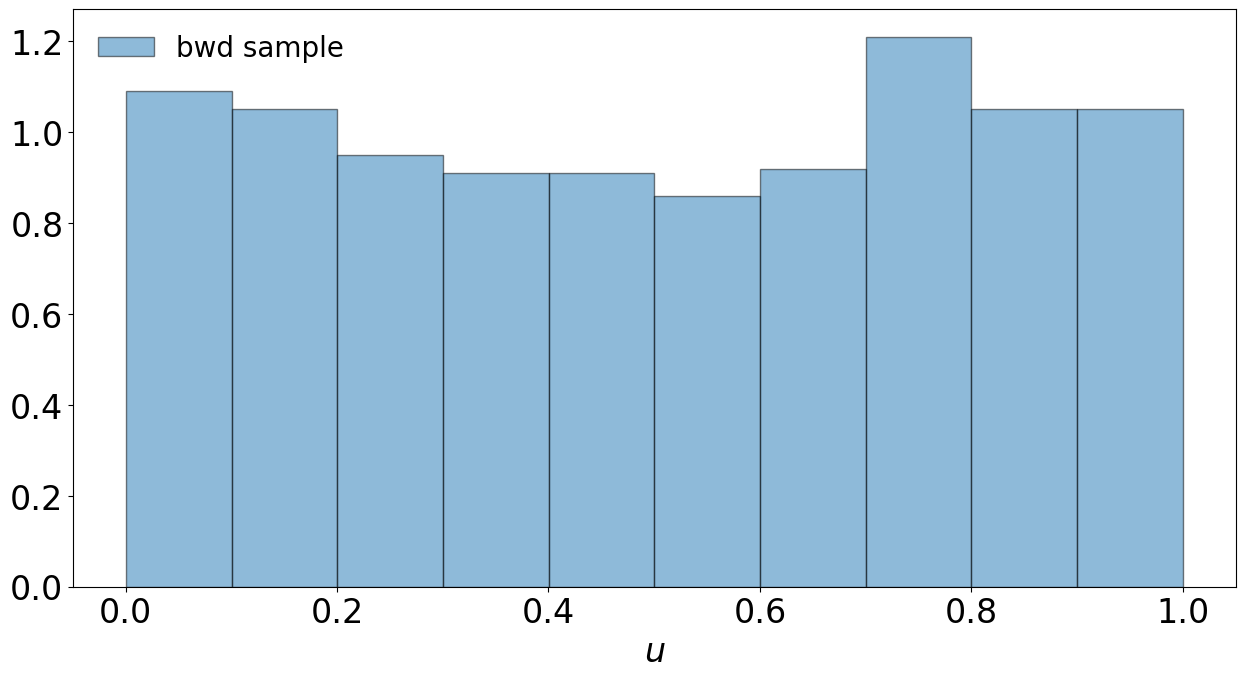

In [80]:
plt.hist(upp,alpha=0.5,density=True,bins=10,ec='black',label='bwd sample');
plt.legend(fontsize='small',frameon=False)
plt.xlabel(r'$u$')

## Stability

Here we show a traceplot of the inverse flow with the (reversed) forward flow
to see if inversion is correct.

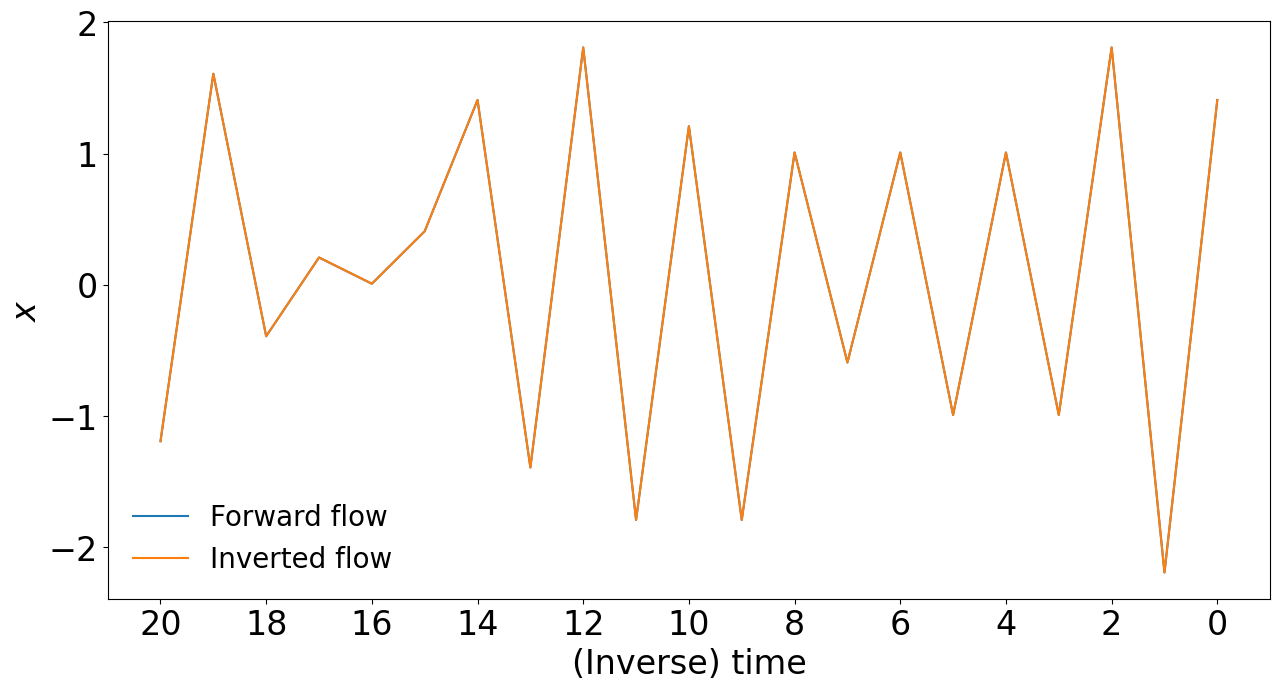

In [81]:
plt.plot(np.arange(0,steps+1),np.flip(xs[:,0,0]),label='Forward flow')
plt.plot(np.arange(0,steps+1),xps[:,0,0],label='Inverted flow')
plt.legend(fontsize='small',frameon=False)
plt.ylabel(r'$x$')
plt.xlabel('(Inverse) time')
plt.xticks(ticks=np.linspace(0,steps,11),
          labels=np.flip(np.linspace(0,steps,11,dtype=int)));

## Sampling

In [82]:
size=10000
sampling_steps=1000
xx,rrho,uu=randqN(size,sampling_steps,randq0,L,epsilon,grad_lp,xi)

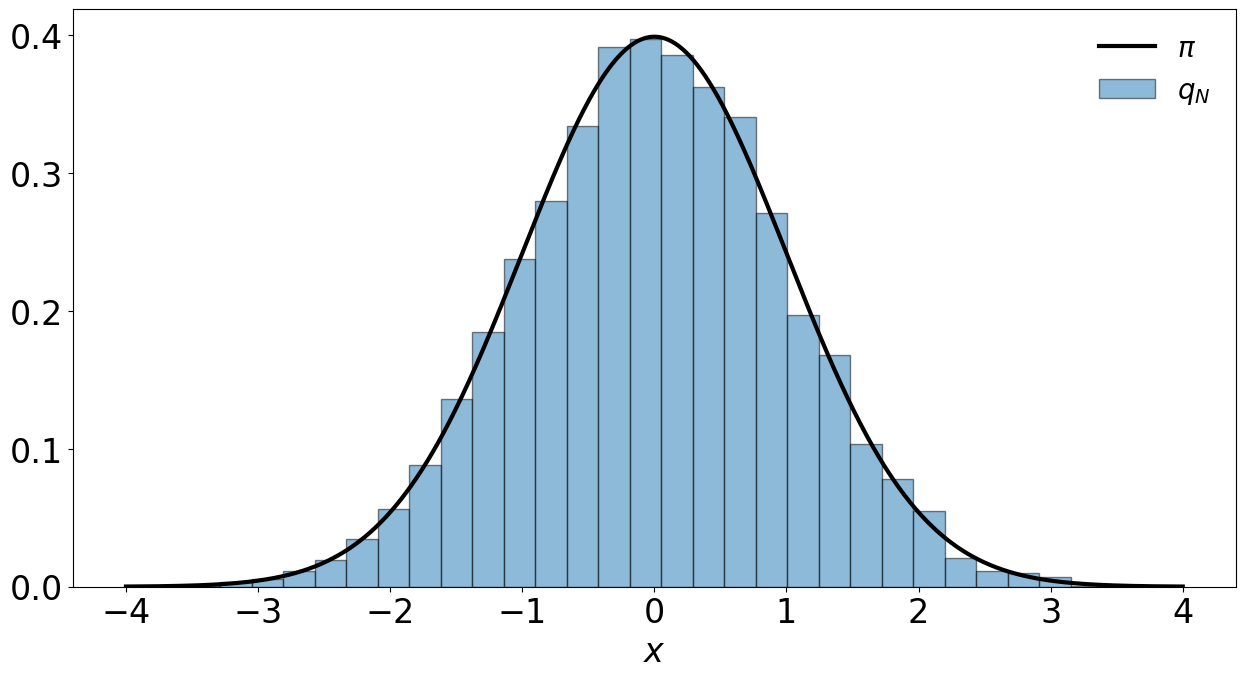

In [83]:
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])),c='black',lw=3,label=r'$\pi$')
plt.hist(xx[0,:],bins=30,density=True,ec='black',alpha=0.5,label=r'$q_N$')
plt.xlabel(r'$x$')
plt.legend(fontsize='small',frameon=False)

## Issue 1: inverting grids instead of pushed samples

In [98]:
new_steps=100
sample_size=1000
initial_x=np.linspace(-4,4,sample_size)[np.newaxis,:]
initial_rho=np.random.laplace(size=1)*np.ones((1,sample_size))
initial_u=np.random.rand()*np.ones(sample_size)
L=50
epsilon=0.1

lq,xs,rhos,us=lqN(initial_x,initial_rho,initial_u,new_steps+1,lq0,L,epsilon,grad_lp,xi)

Flow: 1
x: 0.6000000000000029
rho: -8.58301856127798
J: 0.9988733021355154
total J: 0.9988733021355154
Gaussian weight: 2.482015290210108e-05
Laplace weight: 9.362943552286843e-05
weight: 2.3212785761339385e-09
sum weights: 2.3212785761339385e-09

Flow: 2
x: -1.7999999999999976
rho: 0.0965810126299888
J: 0.0010388929811943602
total J: 0.0010377224626910205
Gaussian weight: 1.921853920371734e-35
Laplace weight: 0.45396817015473223
weight: 9.06393097648277e-39
sum weights: 2.3212785761339385e-09

Flow: 3
x: 1.2000000000000028
rho: 1.6129676662725705
J: 2.204391089988644
total J: 0.0022875461506371582
Gaussian weight: 0.03798662007932575
Laplace weight: 0.09964764684194442
weight: 0.008344231558511026
sum weights: 0.008344233879789602

Flow: 4
x: 0.20000000000000265
rho: -1.1349306290183947
J: 0.3078825077118581
total J: 0.0007042954453647763
Gaussian weight: 2.0252942832745335e-08
Laplace weight: 0.16072220973793552
weight: 1.002187650658748e-09
sum weights: 0.008344234881977252

Flow: 5

In [114]:
rhos=np.linspace(-4,4,100)
lqs=np.zeros((rhos.shape[0],1000))
for i in range(rhos.shape[0]): 
    tmp_lq,_,_,_=lqN(initial_x,rhos[i]*np.ones((1,sample_size)),initial_u,new_steps+1,lq0,L,epsilon,grad_lp,xi)
    lqs[i,:]=np.exp(tmp_lq)

Flow: 1
x: 1.0000000000000024
rho: -11.525925956387255
J: 1.0262649572950833
total J: 1.0262649572950833
Gaussian weight: 0.005140929987637161
Laplace weight: 4.935418249752282e-06
weight: 2.6039050979386205e-08
sum weights: 2.6039050979386205e-08

Flow: 2
x: 1.2000000000000026
rho: 0.04493728446442774
J: 1.1759334104644833e-05
total J: 1.2068192512721946e-05
Gaussian weight: 0.037986620079325684
Laplace weight: 0.4780287198036506
weight: 2.1353416571546716e-07
sum weights: 2.3957321669485335e-07

Flow: 3
x: -1.1999999999999977
rho: 2.3597994650143566
J: 11.08134706863855
total J: 0.00013373182972461708
Gaussian weight: 2.6137153296801685e-25
Laplace weight: 0.04721957982652652
weight: 1.3676436726066122e-25
sum weights: 2.3957321669485335e-07

Flow: 4
x: 1.4000000000000028
rho: -1.9683736888651715
J: 0.7647753458192498
total J: 0.00010227480632468508
Gaussian weight: 0.17996988837729683
Laplace weight: 0.06984192048851774
weight: 0.009612799837459047
sum weights: 0.009613039410675742


x: 1.0000000000000022
rho: 0.1603072781758735
J: 0.18369004190419497
total J: 1.0140548686772947e-05
Gaussian weight: 0.005140929987637143
Laplace weight: 0.42594099200134583
weight: 0.0004022321132340085
sum weights: 0.48124854997020783

Flow: 24
x: 0.40000000000000224
rho: -1.5033641980945776
J: 2.7083200196918904
total J: 2.7463851019047493e-05
Gaussian weight: 8.854339695073359e-07
Laplace weight: 0.11119038367426097
weight: 2.6663882596560563e-07
sum weights: 0.4812488166090338

Flow: 25
x: -1.399999999999998
rho: -0.41304550507421034
J: 0.826695629829947
total J: 2.270424561574729e-05
Gaussian weight: 1.707780634069432e-28
Laplace weight: 0.3308160872608058
weight: 4.670510437370262e-29
sum weights: 0.4812488166090338

Flow: 26
x: 0.8000000000000023
rho: 2.0879221012114866
J: 2.826480770201911
total J: 6.41731136348508e-05
Gaussian weight: 0.0004461007525496307
Laplace weight: 0.06197220618593775
weight: 7.81404572298529e-05
sum weights: 0.48132695706626366

Flow: 27
x: -0.199999

x: 0.4000000000000026
rho: 0.7347865775200849
J: 1.5835858269155823
total J: 1.726363181203151e-05
Gaussian weight: 8.854339695073437e-07
Laplace weight: 0.23980390357019626
weight: 3.3624360564324746e-07
sum weights: 0.009620323458378982

Flow: 16
x: 1.4000000000000028
rho: 0.1858220305760976
J: 1.420537687421636
total J: 2.452363961076184e-05
Gaussian weight: 0.17996988837729683
Laplace weight: 0.4152106857223845
weight: 0.1061502764015966
sum weights: 0.11577059985997559

Flow: 17
x: -1.3999999999999977
rho: -2.266484798045978
J: 6.282029966853961
total J: 0.00015405823893113274
Gaussian weight: 1.707780634069432e-28
Laplace weight: 0.05183799115246431
weight: 5.561350300051991e-29
sum weights: 0.11577059985997559

Flow: 18
x: 2.4000000000000035
rho: 1.5783479296858791
J: 3.6516067355991972
total J: 0.0005625601029554748
Gaussian weight: 0.5467002489199703
Laplace weight: 0.10315783239629531
weight: 0.20593752029308246
sum weights: 0.32170812015305805

Flow: 19
x: -2.599999999999998

x: -0.39999999999999747
rho: -0.11442718630725479
J: 0.7355701975510974
total J: 1.4698748610321897e-05
Gaussian weight: 1.6840903611790636e-14
Laplace weight: 0.44593843845138625
weight: 5.524136787360372e-15
sum weights: 0.009620364541362504

Flow: 11
x: -0.5999999999999975
rho: -0.7082802805144298
J: 2.001412325725837
total J: 2.9418256641443755e-05
Gaussian weight: 6.51055884397428e-17
Laplace weight: 0.24624520749356893
weight: 3.208652058874509e-17
sum weights: 0.009620364541362536

Flow: 12
x: -1.3999999999999977
rho: 0.21847523795772344
J: 1.1773244885960352
total J: 3.463483395577466e-05
Gaussian weight: 1.707780634069432e-28
Laplace weight: 0.40187169076291995
weight: 8.080080284924176e-29
sum weights: 0.009620364541362536

Flow: 13
x: -0.39999999999999747
rho: 1.020892731385523
J: 0.9070275027383418
total J: 3.141474695066341e-05
Gaussian weight: 1.6840903611790636e-14
Laplace weight: 0.18013658470066432
weight: 2.751615647966103e-15
sum weights: 0.009620364541365287

Flow: 

Flow: 1
x: 1.0000000000000024
rho: -10.621688353437595
J: 1.0106333791036308
total J: 1.0106333791036308
Gaussian weight: 0.005140929987637161
Laplace weight: 1.2190720212247654e-05
weight: 6.333805040774151e-08
sum weights: 6.333805040774151e-08

Flow: 2
x: 1.2000000000000026
rho: 0.04495457110115558
J: 2.9045618141716938e-05
total J: 2.9354471210717114e-05
Gaussian weight: 0.037986620079325684
Laplace weight: 0.4780204563662496
weight: 5.274214141368594e-07
sum weights: 5.907594645446009e-07

Flow: 3
x: -1.1999999999999977
rho: 2.359991004235082
J: 11.0790332384374
total J: 0.0003252191622402885
Gaussian weight: 2.6137153296801685e-25
Laplace weight: 0.04721053629112707
weight: 1.367096225437386e-25
sum weights: 5.907594645446009e-07

Flow: 4
x: 1.4000000000000028
rho: -1.9682272076914258
J: 0.7647408873121112
total J: 0.00024870839070253954
Gaussian weight: 0.17996988837729683
Laplace weight: 0.0698521517643339
weight: 0.009613774847118952
sum weights: 0.009614365606583497

Flow: 5


x: -2.3999999999999986
rho: -0.004962823592288335
J: 1.0000100827022138
total J: 0.0001841150879929907
Gaussian weight: 2.5882399436894706e-47
Laplace weight: 0.49752473543494574
weight: 1.2877263768569548e-47
sum weights: 2.9479603669586893

Flow: 93
x: 2.2000000000000033
rho: 0.45534789256203856
J: 0.9996893321129502
total J: 0.00018405788934762986
Gaussian weight: 1.0648266850744996
Laplace weight: 0.31711364330405134
weight: 0.33756616603364253
sum weights: 3.285526532992332

Flow: 94
x: -1.799999999999998
rho: -1.0405254050529755
J: 0.7820213026127969
total J: 0.00014393719038379555
Gaussian weight: 1.9218539203717067e-35
Laplace weight: 0.17663451193000188
weight: 2.6546943176142113e-36
sum weights: 3.285526532992332

Flow: 95
x: 2.2000000000000033
rho: -0.304081977715827
J: 0.9097300400501929
total J: 0.00013094398597256258
Gaussian weight: 1.0648266850744996
Laplace weight: 0.3689001903907169
weight: 0.35735539358521573
sum weights: 3.6428819265775476

Flow: 96
x: -1.9999999999

x: 0.40000000000000246
rho: -0.8839072188890501
J: 0.6429961990519559
total J: 8.020921223498081e-05
Gaussian weight: 8.854339695073437e-07
Laplace weight: 0.20658271302358744
weight: 1.1761387584253007e-07
sum weights: 1.2571038538812827

Flow: 78
x: 0.6000000000000025
rho: 0.31963968800056014
J: 0.6290485074519419
total J: 5.0455485240310725e-05
Gaussian weight: 2.482015290210099e-05
Laplace weight: 0.3632053622134229
weight: 5.670754426715255e-06
sum weights: 1.2571095246357094

Flow: 79
x: 0.4000000000000026
rho: 0.596805035992391
J: 1.1938284739491711
total J: 6.0235194946805106e-05
Gaussian weight: 8.854339695073437e-07
Laplace weight: 0.27528393679107155
weight: 2.9099061543435134e-07
sum weights: 1.257109815626325

Flow: 80
x: 0.2000000000000026
rho: 0.6670075857625636
J: 1.0102547732341265
total J: 6.085289321169794e-05
Gaussian weight: 2.0252942832745335e-08
Laplace weight: 0.2566210575826643
weight: 5.250629065972173e-09
sum weights: 1.257109820876954

Flow: 81
x: 1.60000000

x: 0.6000000000000025
rho: 0.20937194101771955
J: 0.7367430029825095
total J: 6.037126169489004e-05
Gaussian weight: 2.482015290210099e-05
Laplace weight: 0.4055467502954966
weight: 7.415857879703466e-06
sum weights: 1.2561111407574181

Flow: 73
x: -0.39999999999999747
rho: 0.37878099626028205
J: 1.0718745753986498
total J: 6.471042049549107e-05
Gaussian weight: 1.6840903611790636e-14
Laplace weight: 0.34234777356648244
weight: 6.17983482925293e-15
sum weights: 1.2561111407574244

Flow: 74
x: -1.1999999999999975
rho: 0.7887677935652597
J: 2.515448732683516
total J: 0.0001627757452268005
Gaussian weight: 2.6137153296801685e-25
Laplace weight: 0.2272021852223661
weight: 1.4937786898880774e-25
sum weights: 1.2561111407574244

Flow: 75
x: 0.6000000000000025
rho: 1.2928994970429648
J: 0.9647673483310949
total J: 0.00015704072409507833
Gaussian weight: 2.482015290210099e-05
Laplace weight: 0.13723689613140294
weight: 3.2862298520942827e-06
sum weights: 1.2561144269872764

Flow: 76
x: 1.00000

x: 0.8000000000000022
rho: -1.3952917053739182
J: 1.3868244892119095
total J: 0.00020301100472750952
Gaussian weight: 0.0004461007525496299
Laplace weight: 0.12388037634098412
weight: 7.664026080278539e-05
sum weights: 1.198361424178934

Flow: 67
x: -1.399999999999998
rho: -0.6199371255134558
J: 0.8910501394516335
total J: 0.0001808929840726634
Gaussian weight: 1.707780634069432e-28
Laplace weight: 0.26898913081915055
weight: 4.093256484757411e-29
sum weights: 1.198361424178934

Flow: 68
x: 1.4000000000000028
rho: -2.05617200830485
J: 5.022314414393195
total J: 0.0009085014413707364
Gaussian weight: 0.17996988837729683
Laplace weight: 0.06397139882523302
weight: 0.05782153172020064
sum weights: 1.2561829558991346

Flow: 69
x: -0.1999999999999976
rho: -1.7119766755841301
J: 0.31406708044830056
total J: 0.0002853303952743803
Gaussian weight: 2.793140243396716e-12
Laplace weight: 0.09025431636587833
weight: 7.91741009480668e-14
sum weights: 1.256182955899214

Flow: 70
x: 2.414735078559715

x: 0.8000000000000025
rho: 0.5771180271798966
J: 1.374065527624216
total J: 0.00013079743680685722
Gaussian weight: 0.00044610075254963307
Laplace weight: 0.28075715293398523
weight: 0.00017209617975449357
sum weights: 0.5267542769652829

Flow: 59
x: 0.40000000000000246
rho: -1.8055878434091317
J: 2.2871217045030936
total J: 0.0002991496566143351
Gaussian weight: 8.854339695073437e-07
Laplace weight: 0.08218889988210207
weight: 1.6644035071818378e-07
sum weights: 0.5267544434056336

Flow: 60
x: -1.5999999999999979
rho: 0.5369590431256721
J: 0.9116064678940602
total J: 0.00027270676183791486
Gaussian weight: 7.154612452210801e-32
Laplace weight: 0.29226153093495866
weight: 1.9061855228262585e-32
sum weights: 0.5267544434056336

Flow: 61
x: 0.2000000000000026
rho: 1.6474769549647745
J: 0.7831461096079051
total J: 0.00021356923959713257
Gaussian weight: 2.0252942832745335e-08
Laplace weight: 0.09626753548754056
weight: 1.5269006691568075e-09
sum weights: 0.5267544449325343

Flow: 62
x: -1

x: -1.1999999999999977
rho: -0.3118794170719419
J: 1.9357666905196458
total J: 0.00013410780569371482
Gaussian weight: 2.6137153296801685e-25
Laplace weight: 0.36603489901303965
weight: 1.8519693380322377e-25
sum weights: 0.5026588677277002

Flow: 51
x: -0.7999999999999976
rho: 0.7377839913446081
J: 1.173905931357354
total J: 0.00015742994854517144
Gaussian weight: 1.6138061905815658e-19
Laplace weight: 0.23908618821678027
weight: 4.5293842138641614e-20
sum weights: 0.5026588677277002

Flow: 52
x: -0.19999999999999765
rho: 1.019317379431191
J: 0.9817028512243973
total J: 0.00015454942935490512
Gaussian weight: 2.793140243396716e-12
Laplace weight: 0.18042058686436616
weight: 4.947193367192239e-13
sum weights: 0.5026588677281949

Flow: 53
x: -0.5999999999999976
rho: 1.932193405447102
J: 3.5200993552034032
total J: 0.0005440293466192557
Gaussian weight: 6.510558843974187e-17
Laplace weight: 0.0724150892676382
weight: 1.659595545809921e-17
sum weights: 0.5026588677281949

Flow: 54
x: -0.3

Gaussian weight: 0.00044610075254963307
Laplace weight: 0.4840259672491904
weight: 0.00018918640899245821
sum weights: 0.480362487253592

Flow: 33
x: 1.0000000000000024
rho: 0.3790421529249993
J: 1.6931193742025075
total J: 0.00015089494898344136
Gaussian weight: 0.005140929987637161
Laplace weight: 0.34225837883728716
weight: 0.0029790881750973875
sum weights: 0.4833415754286894

Flow: 34
x: -0.5999999999999975
rho: -2.4429391741617312
J: 5.9775971504842955
total J: 0.0009019892170658919
Gaussian weight: 6.51055884397428e-17
Laplace weight: 0.04345252332552389
weight: 1.6910634893466707e-17
sum weights: 0.4833415754286894

Flow: 35
x: 1.2000000000000026
rho: 0.7713578525496289
J: 0.3225228406245674
total J: 0.000290912124500821
Gaussian weight: 0.037986620079325684
Laplace weight: 0.23119239574304373
weight: 0.0028324658003356447
sum weights: 0.486174041229025

Flow: 36
x: -1.399999999999998
rho: 1.8903812886788005
J: 4.048153530542867
total J: 0.001177656943875725
Gaussian weight: 1.

Gaussian weight: 6.51055884397428e-17
Laplace weight: 0.2462971540404013
weight: 3.208990259924409e-17
sum weights: 0.00963303355296141

Flow: 12
x: -1.3999999999999977
rho: 0.2187235690781963
J: 1.1772804588742962
total J: 0.0002827693646141893
Gaussian weight: 1.707780634069432e-28
Laplace weight: 0.4017719059060219
weight: 8.077771893879953e-29
sum weights: 0.00963303355296141

Flow: 13
x: -0.39999999999999747
rho: 1.0211179719411991
J: 0.9070065592028177
total J: 0.00025647366844668267
Gaussian weight: 1.6840903611790636e-14
Laplace weight: 0.18009601520534807
weight: 2.750932421005899e-15
sum weights: 0.009633033552964161

Flow: 14
x: 0.2000000000000026
rho: 0.33519736729020005
J: 0.4420574892298658
total J: 0.00011337610592711352
Gaussian weight: 2.0252942832745335e-08
Laplace weight: 0.35759845797227413
weight: 3.2015664990774515e-09
sum weights: 0.009633036754530661

Flow: 15
x: 0.4000000000000026
rho: 0.7349490203859282
J: 1.5836806339699283
total J: 0.000179551543311693
Gauss

x: 2.2000000000000033
rho: -0.30337271234143426
J: 0.9110850259075106
total J: 0.0008405495490803387
Gaussian weight: 1.0648266850744996
Laplace weight: 0.3691619313332892
weight: 0.3581415793986635
sum weights: 3.6457204443239144

Flow: 96
x: -1.9999999999999982
rho: -0.7538839658832528
J: 1.0309814921768465
total J: 0.000866591028359423
Gaussian weight: 3.310052363327445e-39
Laplace weight: 0.23526772771369847
weight: 8.028752886360606e-40
sum weights: 3.6457204443239144

Flow: 97
x: 1.0000000000000022
rho: 1.463189952564551
J: 0.48817861856558203
total J: 0.00042305121108583043
Gaussian weight: 0.005140929987637143
Laplace weight: 0.115748316184415
weight: 0.0002904926346592732
sum weights: 3.646010936958574

Flow: 98
x: -0.9999999999999974
rho: -2.7089745221377477
J: 2.93831275953611
total J: 0.0012430567714706992
Gaussian weight: 2.564866208902355e-22
Laplace weight: 0.03330253686725208
weight: 2.5098054309378252e-23
sum weights: 3.646010936958574

Flow: 99
x: 0.8000000000000024
r

x: -1.5999999999999979
rho: -1.4404361996822803
J: 0.9753406302615617
total J: 0.0021206968706120443
Gaussian weight: 7.154612452210801e-32
Laplace weight: 0.11841221670296295
weight: 8.263022618643247e-33
sum weights: 2.152219755560325

Flow: 85
x: 1.600000000000003
rho: -1.9650629203134105
J: 1.3290984829118304
total J: 0.0028186149934463353
Gaussian weight: 0.5467002489199859
Laplace weight: 0.07007353412046677
weight: 0.05091672425150791
sum weights: 2.203136479811833

Flow: 86
x: -0.9999999999999974
rho: -1.984563586917419
J: 0.41080915835276993
total J: 0.0011579128531781873
Gaussian weight: 2.564866208902355e-22
Laplace weight: 0.06872029094932919
weight: 7.240854528783249e-24
sum weights: 2.203136479811833

Flow: 87
x: 0.6000000000000023
rho: 2.553081816255235
J: 1.0750364810103064
total J: 0.0012447985589972817
Gaussian weight: 2.4820152902100902e-05
Laplace weight: 0.0389207015334515
weight: 1.0385043366550696e-06
sum weights: 2.2031375183161694

Flow: 88
x: -0.79999999999999

x: -1.1999999999999975
rho: 0.7896429834861944
J: 2.512373393334409
total J: 0.0010295472701777073
Gaussian weight: 2.6137153296801685e-25
Laplace weight: 0.2270034271480635
weight: 1.4906472542221464e-25
sum weights: 1.2576825030975833

Flow: 75
x: 0.6000000000000025
rho: 1.2937438386807918
J: 0.9647375873738401
total J: 0.0009932429495185646
Gaussian weight: 2.482015290210099e-05
Laplace weight: 0.13712107021095793
weight: 3.2833550350388096e-06
sum weights: 1.2576857864526183

Flow: 76
x: 1.0000000000000024
rho: -0.9046352665832419
J: 1.011688679652503
total J: 0.001004852648172594
Gaussian weight: 0.005140929987637161
Laplace weight: 0.20234473097923178
weight: 0.0010523991285675265
sum weights: 1.2587381855811859

Flow: 77
x: 0.40000000000000246
rho: -0.8833358786896554
J: 0.6432001114175615
total J: 0.000646321335262844
Gaussian weight: 8.854339695073437e-07
Laplace weight: 0.20670077575581874
weight: 1.1771841259618051e-07
sum weights: 1.2587383032995985

Flow: 78
x: 0.600000000

x: -1.5999999999999979
rho: 0.5380459599767053
J: 0.9117024921190017
total J: 0.0013402098809569521
Gaussian weight: 7.154612452210801e-32
Laplace weight: 0.2919440395267142
weight: 1.9043153534850365e-32
sum weights: 0.5236718007139239

Flow: 61
x: 0.2000000000000026
rho: 1.6483273455512908
J: 0.781630383512856
total J: 0.001047548763240102
Gaussian weight: 2.0252942832745335e-08
Laplace weight: 0.09618570528032519
weight: 1.522650058640441e-09
sum weights: 0.523671802236574

Flow: 62
x: -1.5999999999999979
rho: -0.15243023713091325
J: 0.7898619398946297
total J: 0.0008274188982670471
Gaussian weight: 7.154612452210801e-32
Laplace weight: 0.4293093957887038
weight: 2.426094398218809e-32
sum weights: 0.523671802236574

Flow: 63
x: 1.8000000000000032
rho: -1.2344000706100808
J: 4.3630427493961825
total J: 0.0036100640247974185
Gaussian weight: 1.0648266850745147
Laplace weight: 0.14550464751890527
weight: 0.675997764422477
sum weights: 1.199669566659051

Flow: 64
x: -1.7999999999999983


x: -0.3999999999999977
rho: 2.668879523276273
J: 9.865252244289023
total J: 0.0033732661380544977
Gaussian weight: 1.6840903611790636e-14
Laplace weight: 0.03466493215204593
weight: 5.7592235827586354e-15
sum weights: 0.49863862120147884

Flow: 48
x: 0.20000000000000237
rho: 0.2953805400264168
J: 0.0885436114764162
total J: 0.0002986811663344484
Gaussian weight: 2.0252942832745193e-08
Laplace weight: 0.37212415864859205
weight: 6.673186067529695e-10
sum weights: 0.4986386218687974

Flow: 49
x: -0.5999999999999976
rho: -0.19110084812198475
J: 1.1314710631176106
total J: 0.0003379490968056461
Gaussian weight: 6.510558843974187e-17
Laplace weight: 0.41302463921602667
weight: 3.0425496958544e-17
sum weights: 0.4986386218687975

Flow: 50
x: -1.1999999999999977
rho: -0.31134695917584865
J: 1.9352685667831047
total J: 0.0006540222642207078
Gaussian weight: 2.6137153296801685e-25
Laplace weight: 0.3662298490820107
weight: 1.8524788820160162e-25
sum weights: 0.4986386218687975

Flow: 51
x: -0.7

x: 1.2000000000000026
rho: 0.772514839614023
J: 0.3240538679621595
total J: 0.0014224432657379668
Gaussian weight: 0.037986620079325684
Laplace weight: 0.23092506381139744
weight: 0.0028426208368581606
sum weights: 0.48108674043270855

Flow: 36
x: -1.399999999999998
rho: 1.8950513199344705
J: 4.024633458254304
total J: 0.00572481275975754
Gaussian weight: 1.707780634069432e-28
Laplace weight: 0.075155310458621
weight: 5.165568094012994e-29
sum weights: 0.48108674043270855

Flow: 37
x: 2.3592239273284576e-15
rho: 1.3145463054069502
J: 0.21002997622405706
total J: 0.0012023822878190552
Gaussian weight: 2.970300062450882e-10
Laplace weight: 0.13429807811172814
weight: 8.378213154182027e-12
sum weights: 0.48108674044108674

Flow: 38
x: 0.20000000000000243
rho: -2.912240947228954
J: 4.541297423662209
total J: 0.005460375585929747
Gaussian weight: 2.0252942832745193e-08
Laplace weight: 0.027176894657748866
weight: 2.4995850238667197e-09
sum weights: 0.4810867429406718

Flow: 39
x: -1.3999999

x: -1.1999999999999973
rho: 1.5229636837113631
J: 0.9701035706255337
total J: 0.0012068851150915168
Gaussian weight: 2.6137153296801685e-25
Laplace weight: 0.10903232683324483
weight: 2.7645959565386683e-26
sum weights: 0.20714066825492145

Flow: 24
x: 2.0000000000000036
rho: -0.23003686541806834
J: 0.9389429580877661
total J: 0.0011331962800361223
Gaussian weight: 1.3298076013381088
Laplace weight: 0.3972521561149054
weight: 0.4960143982313998
sum weights: 0.7031550664863213

Flow: 25
x: -1.3999999999999972
rho: -1.289350766968501
J: 1.0400969204489123
total J: 0.001178633961129734
Gaussian weight: 1.7077806340694807e-28
Laplace weight: 0.13772477800055047
weight: 2.4463465309792584e-29
sum weights: 0.7031550664863213

Flow: 26
x: 1.6000000000000034
rho: -1.6167779084162381
J: 1.8109857759438628
total J: 0.002134489338650321
Gaussian weight: 0.546700248919987
Laplace weight: 0.09926868760014251
weight: 0.09828258963355345
sum weights: 0.8014376561198747

Flow: 27
x: -0.199999999999997

x: -0.39999999999999714
rho: -0.5455415518488932
J: 1.0886831493531524
total J: 0.00051846788677196
Gaussian weight: 1.6840903611790876e-14
Laplace weight: 0.2897639269811015
weight: 5.312650055748826e-15
sum weights: 8.403029651323577e-08

Flow: 8
x: 0.20000000000000304
rho: 0.9211789922654526
J: 1.3711330480710364
total J: 0.0007108884539165867
Gaussian weight: 2.025294283274548e-08
Laplace weight: 0.19902473354194528
weight: 5.526813206075037e-09
sum weights: 8.95571097193108e-08

Flow: 9
x: 1.4000000000000032
rho: -0.4739159243437855
J: 1.6403425359162307
total J: 0.0011661005692511026
Gaussian weight: 0.17996988837729738
Laplace weight: 0.31127979623683494
weight: 0.0918936131010762
sum weights: 0.09189370265818592

Flow: 10
x: -0.5999999999999971
rho: -2.077503178765337
J: 2.010897011485046
total J: 0.0023449081497980543
Gaussian weight: 6.510558843974327e-17
Laplace weight: 0.06262126517214381
weight: 8.198415689653622e-18
sum weights: 0.09189370265818593

Flow: 11
x: 0.40000000

x: -0.5999999999999972
rho: 1.27715977895636
J: 1.2954115335901835
total J: 0.002100362285389661
Gaussian weight: 6.510558843974327e-17
Laplace weight: 0.139414055175351
weight: 1.1757976497973367e-17
sum weights: 3.141777995518189

Flow: 95
x: 0.20000000000000276
rho: -0.4077062436722714
J: 0.3413434845403714
total J: 0.0007169449812920844
Gaussian weight: 2.0252942832745408e-08
Laplace weight: 0.33258712463505474
weight: 2.299244662081651e-09
sum weights: 3.1417779978174334

Flow: 96
x: 0.4000000000000028
rho: -0.08214172055525688
J: 0.7667729667076248
total J: 0.0005497340302714741
Gaussian weight: 8.854339695073469e-07
Laplace weight: 0.46057070238706266
weight: 3.1269380770996266e-07
sum weights: 3.141778310511241

Flow: 97
x: 0.20000000000000281
rho: 0.07814154226394146
J: 0.9380048322925861
total J: 0.0005156531768703216
Gaussian weight: 2.0252942832745408e-08
Laplace weight: 0.4624167571247854
weight: 8.784696793711248e-09
sum weights: 3.141778319295938

Flow: 98
x: 0.400000000

x: 0.8000000000000028
rho: -0.6602691296313413
J: 0.05073748799218249
total J: 0.0011201634632612984
Gaussian weight: 0.00044610075254963464
Laplace weight: 0.25835612659943863
weight: 5.847640727250663e-06
sum weights: 2.975709133034908

Flow: 88
x: 0.20000000000000287
rho: -0.945652554574698
J: 0.985489728514937
total J: 0.001103909587301729
Gaussian weight: 2.0252942832745408e-08
Laplace weight: 0.19421300950344567
weight: 3.8763104949503634e-09
sum weights: 2.9757091369112185

Flow: 89
x: 2.858824288409778e-15
rho: -0.8746372387235531
J: 0.9130037273630114
total J: 0.001007873567878242
Gaussian weight: 2.9703000624509136e-10
Laplace weight: 0.20850663425440996
weight: 5.6544810482384175e-11
sum weights: 2.9757091369677635

Flow: 90
x: -0.5999999999999971
rho: -0.07925412529595109
J: 0.5404338081942809
total J: 0.0005446889504667957
Gaussian weight: 6.510558843974327e-17
Laplace weight: 0.4619025661801921
weight: 1.6252162391602186e-17
sum weights: 2.9757091369677635

Flow: 91
x: -0

Gaussian weight: 0.17996988837729738
Laplace weight: 0.3896005562810603
weight: 0.12977422734902266
sum weights: 5.012526234424565

Flow: 79
x: -1.9999999999999978
rho: -0.26774788450591624
J: 2.8243035004222685
total J: 0.0017663220189277468
Gaussian weight: 3.3100523633274917e-39
Laplace weight: 0.3825503252588438
weight: 3.576307092531253e-39
sum weights: 5.012526234424567

Flow: 80
x: 2.2000000000000037
rho: -0.48921428808261413
J: 1.7914723567387123
total J: 0.0031643170700079706
Gaussian weight: 1.0648266850744985
Laplace weight: 0.30655396559657117
weight: 0.5847846657008854
sum weights: 5.597310900125453

Flow: 81
x: -2.399999999999998
rho: -0.04929324300783408
J: 1.020281893127271
total J: 0.0032284954106426723
Gaussian weight: 2.5882399436894706e-47
Laplace weight: 0.47595097508787565
weight: 1.25686008864736e-47
sum weights: 5.597310900125453

Flow: 82
x: 2.2000000000000037
rho: 0.4284197348112074
J: 0.9824429748198088
total J: 0.0031718126354238862
Gaussian weight: 1.064826

x: 2.400000000000004
rho: 0.03325937983384861
J: 1.4132890802098943
total J: 0.002823605272346499
Gaussian weight: 0.5467002489199692
Laplace weight: 0.4836438160711851
weight: 0.37368521419526307
sum weights: 2.789910291637618

Flow: 67
x: -2.199999999999998
rho: -0.4735864578903114
J: 0.9805193272203516
total J: 0.0027685995419770267
Gaussian weight: 3.655355197963648e-43
Laplace weight: 0.3113823693836168
weight: 1.11604000430887e-43
sum weights: 2.789910291637618

Flow: 68
x: 2.0000000000000036
rho: 0.9512410397795477
J: 0.9186707435776892
total J: 0.002543431399896885
Gaussian weight: 1.3298076013381088
Laplace weight: 0.1931306800810942
weight: 0.23593912624038366
sum weights: 3.0258494178780015

Flow: 69
x: -1.7999999999999976
rho: -1.20498660931064
J: 0.9839033098650586
total J: 0.0025024905727732637
Gaussian weight: 1.921853920371734e-35
Laplace weight: 0.14984800631129228
weight: 2.8335035733190688e-36
sum weights: 3.0258494178780015

Flow: 70
x: 1.6000000000000032
rho: 0.972

x: -1.7999999999999976
rho: -3.0323665581121038
J: 10.348136289593027
total J: 0.02036634853657254
Gaussian weight: 1.921853920371734e-35
Laplace weight: 0.02410071577613399
weight: 4.793055468243058e-36
sum weights: 2.132831585172226

Flow: 55
x: 0.8000000000000029
rho: 1.4782912792808105
J: 0.05760906882290621
total J: 0.001173286374514703
Gaussian weight: 0.00044610075254963464
Laplace weight: 0.1140134950638396
weight: 2.930083996640664e-06
sum weights: 2.1328345152562234

Flow: 56
x: 2.858824288409778e-15
rho: -2.1692090006897207
J: 1.5565934070133434
total J: 0.0018263298351081745
Gaussian weight: 2.9703000624509136e-10
Laplace weight: 0.057133983527901305
weight: 2.6416180063419872e-11
sum weights: 2.1328345152826396

Flow: 57
x: 0.20000000000000287
rho: -0.04807344745116604
J: 0.12231745138205107
total J: 0.0002233920108134335
Gaussian weight: 2.0252942832745408e-08
Laplace weight: 0.4765318922005071
weight: 1.18050690508892e-09
sum weights: 2.1328345164631464

Flow: 58
x: 0.20

x: 1.0000000000000029
rho: 0.10155235072496391
J: 0.9982218515970939
total J: 5.3676959776035576e-05
Gaussian weight: 0.005140929987637188
Laplace weight: 0.4517169413427544
weight: 0.0023181158731331052
sum weights: 1.2128845271580155

Flow: 42
x: 1.200000000000003
rho: 0.06360353586774678
J: 1.1996755978751221
total J: 6.439493881143433e-05
Gaussian weight: 0.037986620079325815
Laplace weight: 0.46918847929913
weight: 0.021381679628873124
sum weights: 1.2342662067868886

Flow: 43
x: -1.999999999999998
rho: 0.299198923474469
J: 3.770462001082049
total J: 0.00024279866985051687
Gaussian weight: 3.310052363327445e-39
Laplace weight: 0.370705955265872
weight: 4.6265684862008355e-39
sum weights: 1.2342662067868886

Flow: 44
x: 2.600000000000004
rho: 0.45092226214356024
J: 5.52829148760775
total J: 0.0013422618197370963
Gaussian weight: 0.17996988837728856
Laplace weight: 0.31852018120269926
weight: 0.31690401042180516
sum weights: 1.5511702172086936

Flow: 45
x: -2.399999999999998
rho: 0.

x: 0.2000000000000027
rho: 0.36144577707602976
J: 0.44864638636263937
total J: 6.569549192089955e-05
Gaussian weight: 2.0252942832745335e-08
Laplace weight: 0.34833418522372556
weight: 3.165107089891957e-09
sum weights: 0.5034219046372725

Flow: 32
x: 1.0000000000000027
rho: -1.3009559618062485
J: 4.168675090052757
total J: 0.0002738631606994162
Gaussian weight: 0.00514092998763717
Laplace weight: 0.13613569376878462
weight: 0.002917505917048475
sum weights: 0.506339410554321

Flow: 33
x: 2.8033131371785203e-15
rho: 0.5270322819990509
J: 0.27973188732859994
total J: 7.660825881222334e-05
Gaussian weight: 2.9703000624509136e-10
Laplace weight: 0.2951771889166917
weight: 2.4525907858973727e-11
sum weights: 0.5063394105788469

Flow: 34
x: 1.6000000000000032
rho: -0.15050601836455157
J: 2.5407560637628226
total J: 0.00019464289811146806
Gaussian weight: 0.5467002489199865
Laplace weight: 0.43013627627899914
weight: 0.5974730402853867
sum weights: 1.1038124508642335

Flow: 35
x: -1.79999999

x: -0.5999999999999971
rho: -0.4411189778752826
J: 0.9824286522551429
total J: 4.483337802256512e-05
Gaussian weight: 6.510558843974327e-17
Laplace weight: 0.32165808081471176
weight: 2.0573764056028648e-17
sum weights: 0.38899924079304765

Flow: 22
x: -0.39999999999999714
rho: -0.6892772862817776
J: 1.1596964715322864
total J: 5.1993110299641974e-05
Gaussian weight: 1.6840903611790876e-14
Laplace weight: 0.2509693479969227
weight: 4.901515816563933e-15
sum weights: 0.38899924079305254

Flow: 23
x: -0.599999999999997
rho: 0.48882546866395277
J: 0.9044286888916788
total J: 4.702406057970565e-05
Gaussian weight: 6.510558843974327e-17
Laplace weight: 0.30667318290676343
weight: 1.805794804236172e-17
sum weights: 0.3889992407930526

Flow: 24
x: 0.400000000000003
rho: 0.27494615529491734
J: 0.681286999042153
total J: 3.2036881115124096e-05
Gaussian weight: 8.854339695073517e-07
Laplace weight: 0.37980651163152396
weight: 2.2911244884693417e-07
sum weights: 0.38899946990550144

Flow: 25
x: -

x: 1.4000000000000032
rho: 0.07663717883288722
J: 1.1714487422015636
total J: 8.6411371704663e-05
Gaussian weight: 0.17996988837729738
Laplace weight: 0.4631129234964346
weight: 0.09763601336256884
sum weights: 0.0977427157940002

Flow: 11
x: -1.9999999999999978
rho: -1.9471899077711556
J: 17.050387204209077
total J: 0.0014733473464113398
Gaussian weight: 3.3100523633274917e-39
Laplace weight: 0.07133721855900908
weight: 4.02610671798237e-39
sum weights: 0.0977427157940002

Flow: 12
x: 1.8000000000000034
rho: 1.2160673449813622
J: 0.3594223021376725
total J: 0.0005295538950955946
Gaussian weight: 1.0648266850745154
Laplace weight: 0.14819674564951651
weight: 0.05671822284069956
sum weights: 0.15446093863469976

Flow: 13
x: -1.3999999999999972
rho: -1.6073822379430767
J: 0.8750715864157534
total J: 0.0004633975670739437
Gaussian weight: 1.7077806340694807e-28
Laplace weight: 0.10020577888383853
weight: 1.4975055307142802e-29
sum weights: 0.15446093863469976

Flow: 14
x: 2.60000000000000

x: 1.200000000000003
rho: 0.23516857385697737
J: 1.0020739393928004
total J: 2.0829278467308894e-05
Gaussian weight: 0.037986620079325815
Laplace weight: 0.39521879564182594
weight: 0.015044162344775416
sum weights: 1.1995396715299342

Flow: 98
x: 2.858824288409778e-15
rho: -1.879425343976779
J: 2.171473744928957
total J: 4.523023131757533e-05
Gaussian weight: 2.9703000624509136e-10
Laplace weight: 0.0763389088899742
weight: 4.923805117554446e-11
sum weights: 1.1995396715791722

Flow: 99
x: -0.999999999999997
rho: -0.5542742678953412
J: 0.43816879064042763
total J: 1.9818475756808778e-05
Gaussian weight: 2.5648662089023915e-22
Laplace weight: 0.2872445175407912
weight: 3.2281812089951583e-23
sum weights: 1.1995396715791722

Flow: 100
x: -0.9999999999999969
rho: 0.6097846869430541
J: 1.0897420808430476
total J: 2.15970270103623e-05
Gaussian weight: 2.5648662089023915e-22
Laplace weight: 0.27173393610340674
weight: 7.595079380281098e-23
sum weights: 1.1995396715791722

Flow: 1
x: -0.3999

x: -0.19999999999999715
rho: -1.7694825249468011
J: 0.09380834142701552
total J: 6.477243493246428e-05
Gaussian weight: 2.7931402433967356e-12
Laplace weight: 0.08521057735385913
weight: 2.2326863003949288e-14
sum weights: 1.1842926539968284

Flow: 90
x: 2.858824288409778e-15
rho: -0.15531514714106198
J: 0.19511476056542487
total J: 1.2638058133087337e-05
Gaussian weight: 2.9703000624509136e-10
Laplace weight: 0.4280726616065009
weight: 2.4808924798021942e-11
sum weights: 1.1842926540216372

Flow: 91
x: -0.9999999999999969
rho: -0.03449686470946137
J: 1.363681445989235
total J: 1.723428538942454e-05
Gaussian weight: 2.5648662089023915e-22
Laplace weight: 0.48304568432943545
weight: 1.6895297907062816e-22
sum weights: 1.1842926540216372

Flow: 92
x: 2.9698465908722937e-15
rho: -0.542015217117451
J: 1.0075466861827262
total J: 1.7364347132842082e-05
Gaussian weight: 2.9703000624509136e-10
Laplace weight: 0.2907875353128228
weight: 8.702445051376712e-11
sum weights: 1.1842926541086616

Fl

x: -0.19999999999999715
rho: -0.09710050861332023
J: 0.800661694138228
total J: 1.4397182730014469e-05
Gaussian weight: 2.7931402433967356e-12
Laplace weight: 0.45373239676074456
weight: 1.0147091639696535e-12
sum weights: 0.40024582183105023

Flow: 78
x: -1.3999999999999972
rho: 0.47570621210732744
J: 3.732929369870245
total J: 5.3743666256259714e-05
Gaussian weight: 1.7077806340694807e-28
Laplace weight: 0.31072301437518435
weight: 1.980866825071892e-28
sum weights: 0.40024582183105023

Flow: 79
x: 3.0253577421035516e-15
rho: 1.3534780688018773
J: 0.9028235550212964
total J: 4.852104782935446e-05
Gaussian weight: 2.970300062450924e-10
Laplace weight: 0.12917008568835678
weight: 3.4638984663347486e-11
sum weights: 0.40024582186568936

Flow: 80
x: -0.9999999999999971
rho: 1.4172048917240128
J: 2.0736638933661147
total J: 0.00010061634495202263
Gaussian weight: 2.564866208902355e-22
Laplace weight: 0.12119528941877486
weight: 6.44597804355177e-23
sum weights: 0.40024582186568936

Flow: 

x: -0.19999999999999737
rho: -1.7536996311326791
J: 1.6456928723679114
total J: 9.034195538537294e-05
Gaussian weight: 2.793140243396716e-12
Laplace weight: 0.08656611586972975
weight: 3.979142222201429e-13
sum weights: 0.10021386522783716

Flow: 68
x: 2.8033131371785203e-15
rho: 0.8028979396418144
J: 0.3787792522449548
total J: 3.4219658307218645e-05
Gaussian weight: 2.9703000624509136e-10
Laplace weight: 0.2240143604115716
weight: 2.5203587692527894e-11
sum weights: 0.10021386525304075

Flow: 69
x: 1.400000000000003
rho: -0.5589282256067118
J: 2.455115568174794
total J: 8.401321584767435e-05
Gaussian weight: 0.1799698883772971
Laplace weight: 0.2859107996439632
weight: 0.12632879328218352
sum weights: 0.22654265853522426

Flow: 70
x: -1.199999999999997
rho: -2.1301644453005775
J: 3.9389229740175
total J: 0.0003309215860234956
Gaussian weight: 2.6137153296802057e-25
Laplace weight: 0.05940887661231425
weight: 6.116276542678257e-26
sum weights: 0.22654265853522426

Flow: 71
x: 1.800000

x: 0.2000000000000027
rho: 0.07169259596959081
J: 1.0004610389154323
total J: 5.635050047756764e-06
Gaussian weight: 2.0252942832745335e-08
Laplace weight: 0.46540849436490184
weight: 9.430237333100618e-09
sum weights: 0.9913663947819783

Flow: 59
x: 2.6922908347160046e-15
rho: 0.17247896269525567
J: 1.0841392636046538
total J: 6.109179009150391e-06
Gaussian weight: 2.9703000624508924e-10
Laplace weight: 0.42078799655808996
weight: 1.355029468831091e-10
sum weights: 0.9913663949174812

Flow: 60
x: 0.6000000000000028
rho: 0.737265208100488
J: 2.1059912215646697
total J: 1.2865877364237876e-05
Gaussian weight: 2.482015290210108e-05
Laplace weight: 0.2392102543040488
weight: 1.2503764974802843e-05
sum weights: 0.9913788986824561

Flow: 61
x: 1.2000000000000028
rho: 0.19791176474778574
J: 1.000646765710088
total J: 1.2874198572547264e-05
Gaussian weight: 0.03798662007932575
Laplace weight: 0.41022112093615193
weight: 0.015592992363870798
sum weights: 1.006971891046327

Flow: 62
x: 2.636779

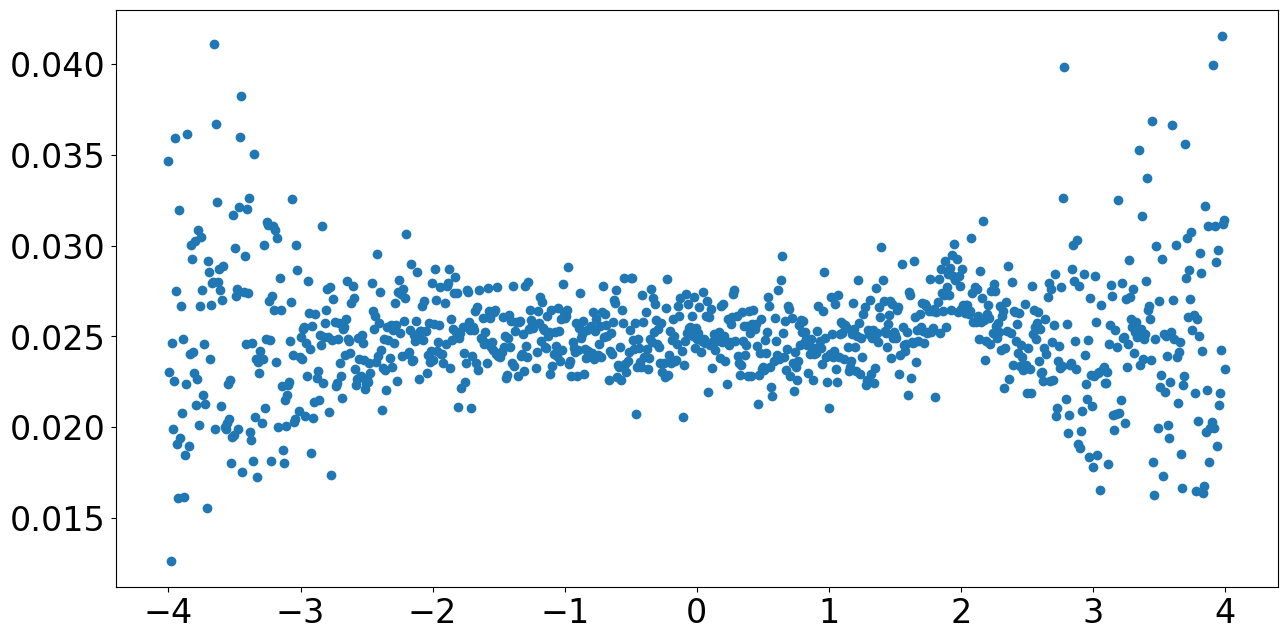

In [118]:
plt.scatter(initial_x[0,:],np.mean(lqs,axis=0))

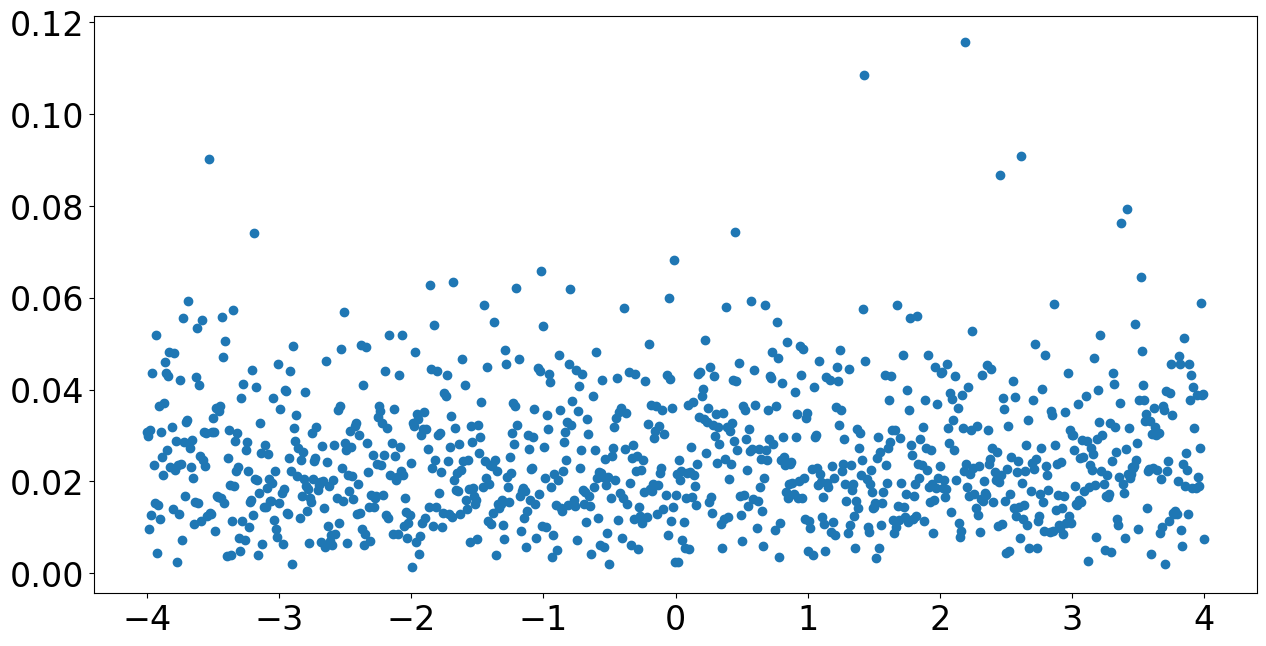

In [99]:
plt.scatter(initial_x,np.exp(lq))

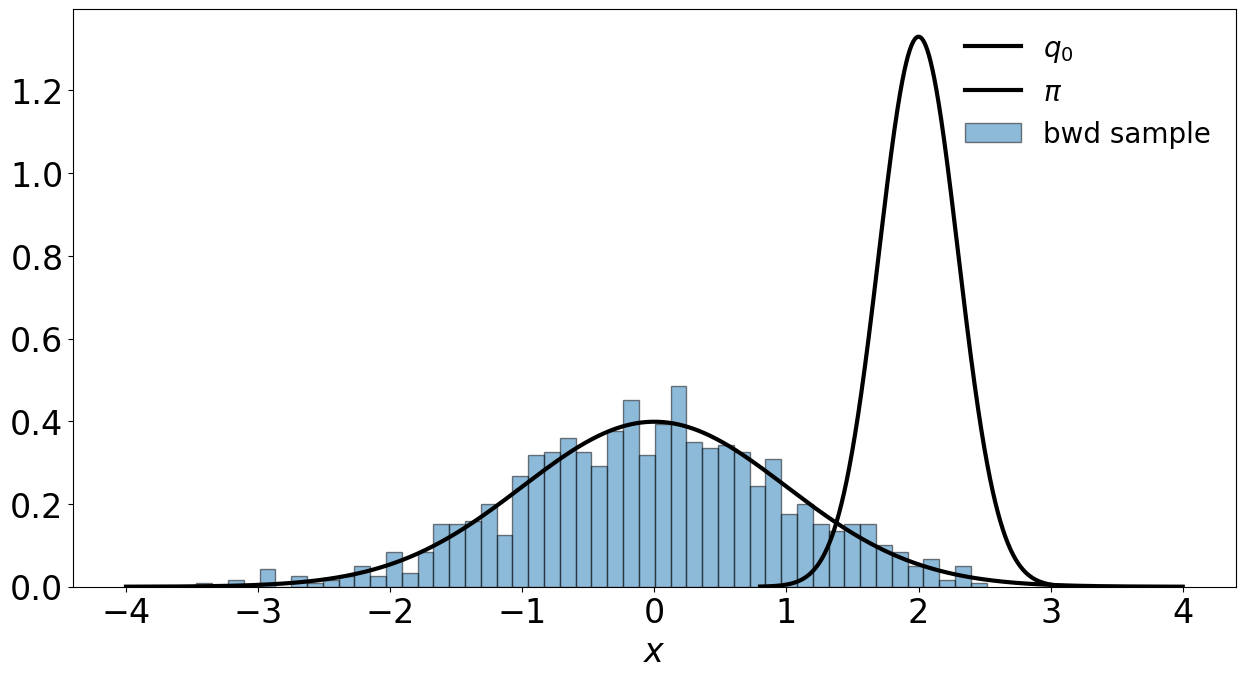

In [89]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(gauss_lp(ttx[np.newaxis,:],mu0,sigma0)),c='black',lw=3,label=r'$q_0$')
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])),c='black',lw=3,label=r'$\pi$')
plt.hist(final_x[0,:],alpha=0.5,density=True,bins=50,ec='black',label='bwd sample');
plt.xlabel(r'$x$')
plt.legend(fontsize='small',frameon=False)

## Issue 2: density

In [86]:
lq,xs,rhos,us=lqN(xp,rhop,up,steps+1,lq0,L,epsilon,grad_lp,xi)

Flow: 1
x: 1.609477756976012
rho: -1.3099068322069733
J: 0.08781741099614863
total J: 0.08781741099614863
Gaussian weight: 0.5699365174831401
Laplace weight: 0.134922598047471
weight: 0.0067529231738985
sum weights: 0.0067529231738985

Flow: 2
x: -0.39052224302398864
rho: -1.7050786748425693
J: 0.443803096205485
total J: 0.03897363890084037
Gaussian weight: 2.167266541675689e-14
Laplace weight: 0.09087904291202402
weight: 8.741106241904111e-16
sum weights: 0.006752923173899374

Flow: 3
x: 0.20947775697601137
rho: -0.09142019152355471
J: 0.2051758933790706
total J: 0.007996451179713223
Gaussian weight: 2.4467756849108098e-08
Laplace weight: 0.45631707459331217
weight: 2.290800180876755e-09
sum weights: 0.006752925464699555

Flow: 4
x: 0.009477756976011414
rho: 0.10280696132682501
J: 0.9455372305583524
total J: 0.007560942302761112
Gaussian weight: 3.6648256286791246e-10
Laplace weight: 0.45115056784249613
weight: 1.5633400650803018e-10
sum weights: 0.006752925621033561

Flow: 5
x: 0.409

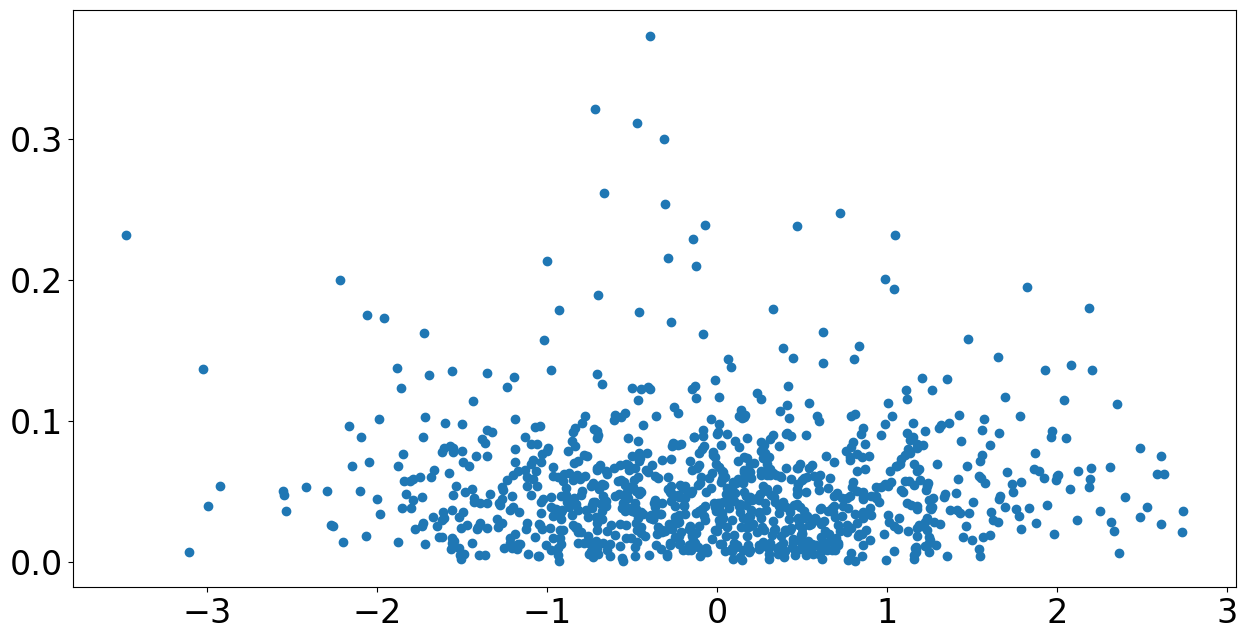

In [87]:
plt.scatter(xp,np.exp(lq))

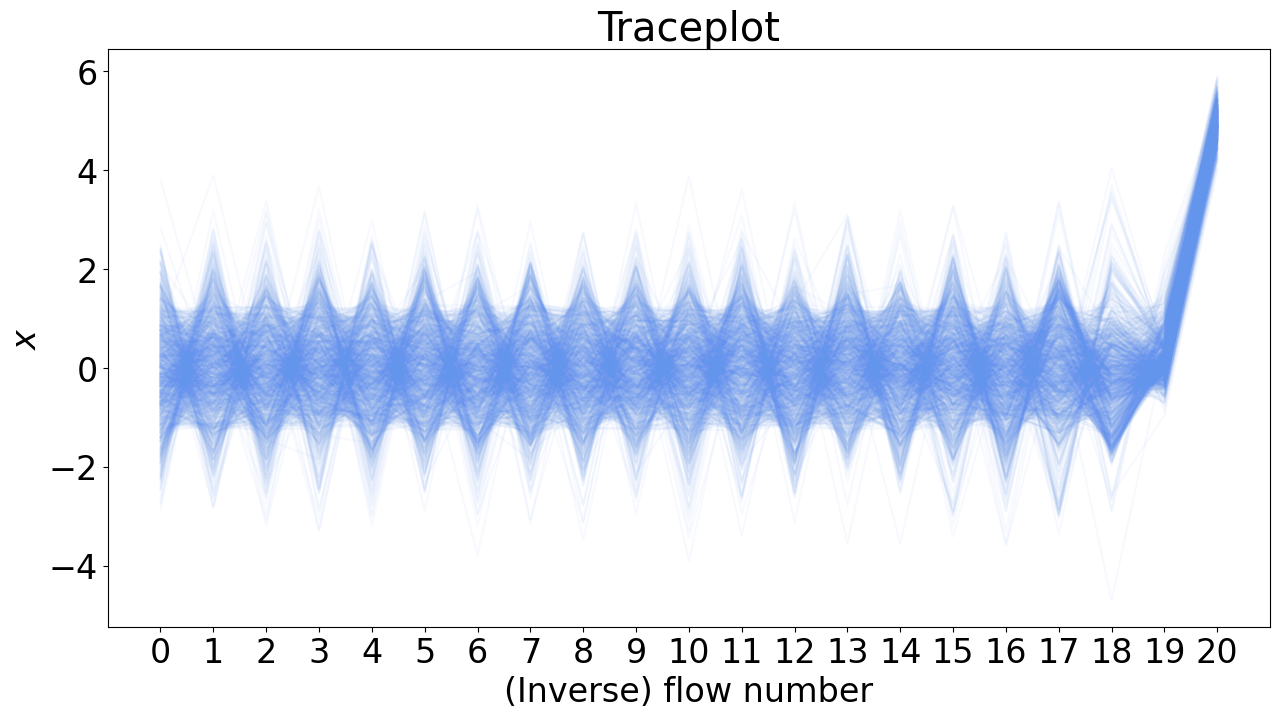

In [68]:
for n in range(xs.shape[-1]): plt.plot(np.arange(0,xs.shape[0]),xs[:,0,n],c='cornflowerblue',alpha=0.05)
plt.xlabel('(Inverse) flow number')
plt.ylabel(r'$x$')
plt.title('Traceplot')
plt.xticks(ticks=np.arange(0,steps+1));